In [1]:
from bmtk.builder.networks import NetworkBuilder
from bmtk.utils.sim_setup import build_env_bionet
import json
from edit_genome import process_json
from bmtk.simulator import bionet
from bmtk.analyzer.spike_trains import to_dataframe
from bmtk.analyzer.cell_vars import plot_report
import os
import shutil
from neuron import h
import ipywidgets as widgets
from ipywidgets import HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
%matplotlib inline

In [2]:
net = NetworkBuilder('BL')
net.add_nodes(cell_name='BL',
          potental='exc',
          model_type='biophysical',
          model_template='ctdb:Biophys1.hoc',
          model_processing='aibs_allactive',
          dynamics_params='BL_fit.json',
          morphology='reconstruction.swc')
shutil.rmtree('./network')
net.build()
net.save_nodes(output_dir='network')
build_env_bionet(network_dir='network', tstop=2000.0, dt=0.1,
                 report_vars=['v']
                )

shutil.copy('sources/BL_fit.json','components/biophysical_neuron_models/')
shutil.copy('sources/neuronal_model_491766131/reconstruction.swc','components/morphologies/')
shutil.rmtree('components/mechanisms/')
shutil.copytree('sources/modfiles','components/mechanisms/modfiles')
shutil.copytree('sources/x86_64','components/mechanisms/x86_64')

with open("./simulation_config.json",'r') as load_f:
        load_dict = json.load(load_f)
        #print(load_dict)
        load_dict['inputs'] =  {"current_clamp1": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": "all",
        "amp": 0.3,
        "delay": 300.0,
        "duration": 1000.0
        }
        }
with open("./simulation_config.json",'w') as dump_f:
    json.dump(load_dict,dump_f)


In [3]:
filePath = './sources/modfiles'
a = os.listdir(filePath)

w_0 = widgets.Checkbox(value=False,description=a[2],disabled=False)
w_1 = widgets.Checkbox(value=False,description=a[18],disabled=False)
w_2 = widgets.Checkbox(value=False,description=a[12],disabled=False)

def update_0(*args):
    if w_0.value:
        text0 = widgets.FloatText(
            value=0.00095782168667023497,
            description='NaP:',
            min=0,
            max=0.01,
            step=0.00005,
            disabled=False
        )
        value0 = text0.value
        process_json('./components/biophysical_neuron_models/BL_fit.json','Nap',value0)
        display(text0)
def update_1(*args):
    if w_1.value:
        text1 = widgets.FloatText(
            value=0.00045041730360183556,
            description='Ih:',
            min=0,
            max=0.01,
            step=0.00005,
            disabled=False
        )
        value1 = text1.value
        process_json('./components/biophysical_neuron_models/BL_fit.json','Ih',value1)
        display(text1)        
def update_2(*args):
    if w_2.value:
        text2 = widgets.FloatText(
            value=0.00011215709095308002,
            description='Im:',
            min=0,
            max=0.01,
            step=0.00005,
            disabled=False
        )
        value2 = text2.value
        process_json('./components/biophysical_neuron_models/BL_fit.json','Im',value2)
        display(text2)              
        
w_0.observe(update_0,'value')
w_1.observe(update_1,'value')
w_2.observe(update_2,'value')
ui1 = HBox([VBox([Label('Channels')],layout=Layout(width='10%')),VBox([w_0,w_1,w_2],layout=Layout(width='38%'))])


In [4]:
conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)

pc = h.ParallelContext()
hcell = pc.gid2cell(0)
clear_output()

In [5]:
FloatText1 = widgets.FloatText(
    value=-38.43,
    description='Vhalf_m:',
    disabled=False
)
FloatText2 = widgets.FloatText(
    value=-52.7,
    description='Vhalf_n:',
    disabled=False
)
FloatText4 = widgets.FloatText(
    value=7.2,
    description='K_m:',
    disabled=False
)


FloatText5 = widgets.FloatText(
    value=10.34,
    description='K_n:',
    disabled=False
)


ui2 = HBox([VBox([Label('Vhalf&slope')],layout=Layout(width='10%')),VBox([FloatText1,FloatText2,FloatText4,FloatText5],layout=Layout(width='38%'))])
ui2




In [7]:
hcell.soma[0].mhalf_Nap = FloatText1.value
hcell.soma[0].vhalf_im  = FloatText2.value
hcell.soma[0].slope1_Nap = FloatText4.value
hcell.soma[0].k_im = FloatText5.value

In [8]:
sim.run()
clear_output()

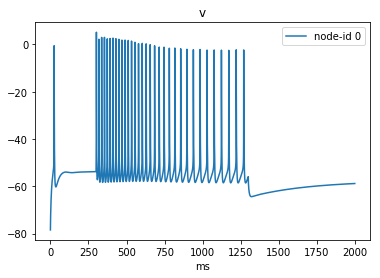

In [9]:
to_dataframe(config_file='simulation_config.json')
plot_report(config_file='simulation_config.json')